# Generate the omega Test Plot
### Setup

In [1]:
from __future__ import division

import os

from pymongo import MongoClient
from pandas import DataFrame
from numpy import linspace

from cogent.maths.stats import chisqprob
from IPython.display import display, Image

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [3]:
try:
    os.mkdir('omega_test')
except OSError:
    pass

### Utility

In [4]:
def get_ps(nul_col, alt_col):
    nul_fits = {d['_id'] : (d['lf']['ll'], d['lf']['df']) for d in nul_col.find()}
    alt_fits = {d['_id'] : (d['lf']['ll'], d['lf']['df']) for d in alt_col.find()}
    ps = []
    for _id in nul_fits:
        alt_ll, alt_df = alt_fits[_id]
        nul_ll, nul_df = nul_fits[_id]
        lr = 2.*(alt_ll - nul_ll)
        df = alt_df - nul_df
        ps.append(0. if lr < 0. else chisqprob(lr, df))
    ps = sorted(ps)
    print sum(1 for p in ps if p < 0.05)/len(ps)
    return ps

### Load the Data

In [5]:
client = MongoClient('mongodb://localhost:27016')

In [8]:
print 'GNC'
ps = get_ps(client.mammals.GNC_omega, client.mammals.GNC)
ys = linspace(0., 1., len(ps)).tolist()
model = ['GNC']*len(ps)
print 'Y98'
ps += get_ps(client.mammals.Y98_omega, client.mammals.Y98)
ys += linspace(0., 1., len(ps) - len(model)).tolist()
model += ['Y98']*(len(ps) - len(model))
print 'CNFGTR'
ps += get_ps(client.mammals.CNFGTR_omega, client.mammals.CNFGTR)
ys += linspace(0., 1., len(ps) - len(model)).tolist()
model += ['CNFGTR']*(len(ps) - len(model))

df = DataFrame({'p':ps, 'y':ys, 'model':model})
print len(df)/3, 'points'

GNC
0.267228915663
Y98
0.166024096386
CNFGTR
0.16578313253
4150.0 points


### Draw the Plot

In [10]:
%%R -i df
gg <- ggplot(df, aes(p, y, linetype=model)) + geom_line() +
    theme(legend.position = c(0.85, 0.15)) +
    ylab('Empirical CDF') + 
    xlab(expression(paste('LRT P-value for Human/Mouse ', omega, ' equal')))

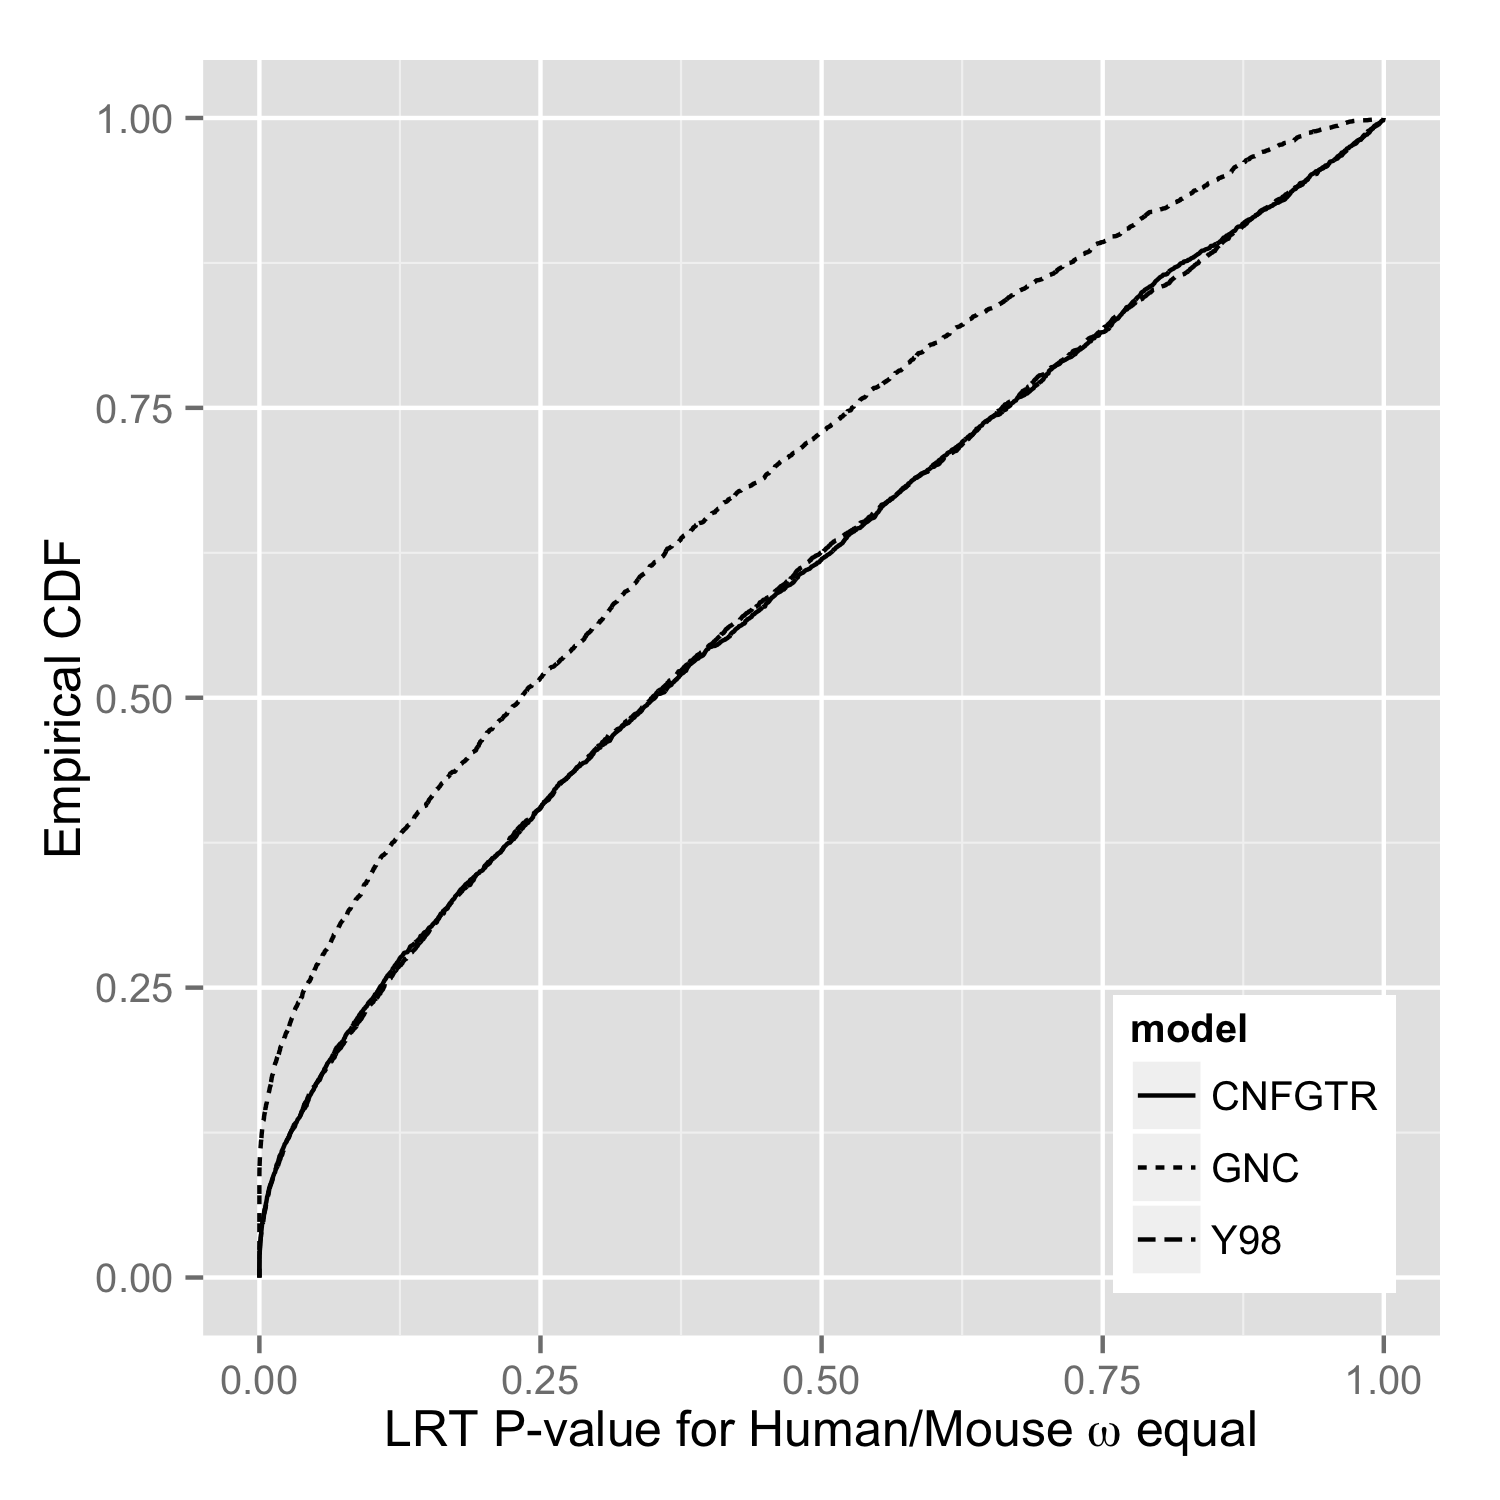

In [11]:
name = os.path.join('omega_test', 'omega_test.png')
%R -i name ggsave(name, gg, width=5, height=5)
display(Image(name))

In [12]:
sum(p == 0. for p in ps)/len(ps)

0.027871485943775101